In [2]:
from sys import version_info
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.data import page
from skimage.filters import threshold_sauvola
print('Python version: ' + str(version_info[:3]))
print('OpenCV version: ' + cv2.__version__)
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
            
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    cv2.imwrite("output_files/biggest_component.png", img2)
    return img2

def inverted(imagem):
    imagem = (255-imagem)
    return imagem
    
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2.imwrite('output_files/connected_components.png', labeled_img)

Python version: (3, 7, 3)
OpenCV version: 4.1.0


In [3]:
#Read image, and perform binarization using Otsu algorithm
img = cv2.imread('input_files/test4.jpg')  #Afbeelding waar je alles op uitvoert
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.imwrite('output_files/binary_sauvola.png', gray)
#Perform OTSU binarization
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#Fooling around with sauvola binarization. Work in progress though. 
window_size = 25
#thresh_sauvola = threshold_sauvola(img, window_size=window_size)
#binary_sauvola = img > thresh_sauvola
#binary_sauvola  = binary_sauvola.astype('uint8')
#binary_sauvola[binary_sauvola == 1 ] = 255
cv2.imwrite('output_files/binary_sauvola.png', binary_sauvola)

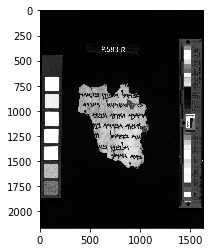

In [4]:
plt.imshow(img)

In [ ]:
#Perform OTSU binarization
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Fooling around with sauvola binarization. Work in progress though. 
window_size = 25
thresh_sauvola = threshold_sauvola(img, window_size=window_size)
binary_sauvola = img > thresh_sauvola
binary_sauvola  = binary_sauvola.astype('uint8')
binary_sauvola[binary_sauvola == 1 ] = 255
cv2.imwrite('output_files/binary_sauvola.png', binary_sauvola)

#Show  and save image
cv2.imwrite('output_files/otsu.png',thresh)
#Find connected components of image
output_components = cv2.connectedComponentsWithStats(cv2.bitwise_not(thresh))
# The first cell is the number of labels
num_labels = output_components[0]
# The second cell is the label matrix
labels = output_components[1]
# The third cell is the stat matrix
stats = output_components[2]
# The fourth cell is the centroid matrix
centroids = output_components[3]
#Show the components of the image
imshow_components(labels)

#Get the biggest components, the dead sea scroll.
largest_component = undesired_objects(cv2.bitwise_not(thresh))
#Convert to right type
largest_component = largest_component.astype('uint8')
#Save file for debugging purposes. 
cv2.imwrite('output_files/is_dit_het_nou.png', largest_component)

largest_component_copy = largest_component
_, contours, hierarchy = cv2.findContours(largest_component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

print(bounding_boxes)
x = bounding_boxes[0][0]
y = bounding_boxes[0][1]
width = bounding_boxes[0][2]
height = bounding_boxes[0][3]
#Crop the image to get only the scroll
crop_img = largest_component_copy[y:y+height, x:x+width]
cv2.imwrite('output_files/crop.png', crop_img)
#Draw rectangle around the largest component to see what is being cropped. 
cv2.rectangle(largest_component_copy,(x,y),(x+width,y+height),(255,0,0),2)
cv2.imwrite('output_files/vierkant.png', largest_component_copy)

crop_img2 = img[y:y+height, x:x+width]


# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(crop_img,cv2.MORPH_OPEN,kernel, iterations = 2)
#Save image for debugging
cv2.imwrite('output_files/opening.png',opening)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
#Save image for debugging
cv2.imwrite('output_files/dist_transform.png',dist_transform)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

cv2.imwrite('output_files/fg.png',sure_fg)
cv2.imwrite('output_files/bg.png',sure_bg)
cv2.imwrite('output_files/unkown.png',unknown)


# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
cv2.imwrite('output_files/markers.png',markers)

#Perform watershed and save the result. 
markers = cv2.watershed(crop_img2,markers)
crop_img2[markers == -1] = [0,255,0]
cv2.imwrite('output_files/watershed_output.png',crop_img2)

